# CSGO Analysis - Weapons

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
%matplotlib inline

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings("ignore")

#All libraries used

# Importing the Data for Use

Like the other datasets, the master demos csv had to be culled to meet the 100mb byte limit on github. I also created another csv which has the weapon names as long as which category they belong to and the cost. This is so I can do some analysis based on cost and the amount of kills and see if there is a correlation.

In [2]:
df = pd.read_csv('data/mm_master_demos.csv',index_col = 0)
weapons = pd.read_csv('data/weapons.csv',index_col = 0)

#Reading in the csv's and creating another dataframe with just weapon and their types

main_maps = ['de_cache', 'de_cbble', 'de_dust2', 'de_inferno', 'de_mirage', 'de_overpass', 'de_train']
df = df[df['map'].isin(main_maps)]
df = df.reset_index(drop=True)
#Hits will be the dataframe is use the most
hits = df[['wp','wp_type','hitbox','hp_dmg','att_rank']]

The dataset I am using has a lot of data in it however I will just be looking at the columns for the weapon, weapon type, hitbox (where it hit on the body) and the damage that it dealt. To get an idea about the data i'll graph the amount of hits for each weapon class (rifle, sniper, pistol etc.)

# Weapon Analysis

This will be looking at weapon stats in master_demos.

Text(0,0.5,'Number of hits')

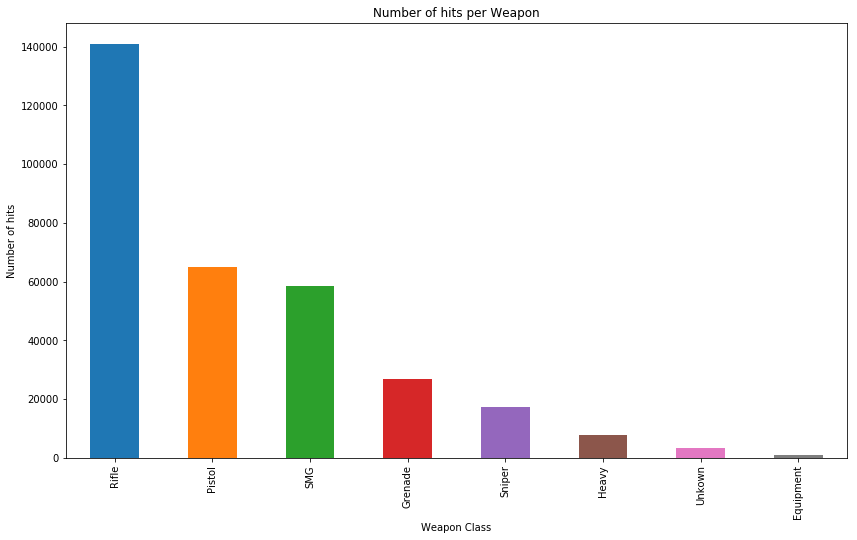

In [4]:
plot = hits['wp_type'].value_counts().plot(kind='bar',figsize=(14,8), title="Number of hits per Weapon",)
plot.set_xlabel("Weapon Class")
plot.set_ylabel("Number of hits")

As you can see rifles are the most common weapon to get a hit with, with pistol and smg a close second and thirds. It's important to note that this is not a complete list as the sniper class would be used a lot more however it is only one shot and thus does not show up that often on this dataset.

To give us an better idea of splits we should look at the weapons specifically.

Text(0,0.5,'Number of hits')

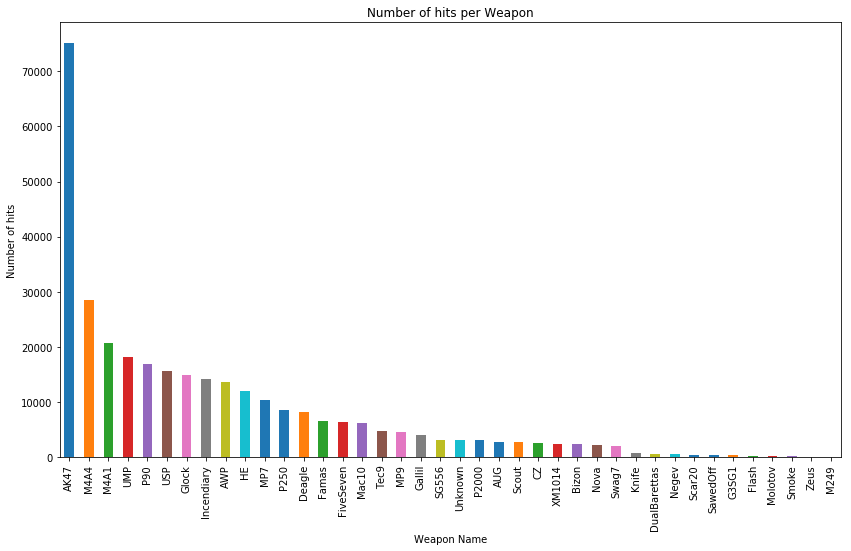

In [31]:
plot = hits['wp'].value_counts().plot(kind='bar',figsize=(14,8), title="Number of hits per Weapon",)
plot.set_xlabel("Weapon Name")
plot.set_ylabel("Number of hits")

This plot tells quite an interesting story as it has the AK-47 as the one with the highest number of hits and it as a Terrorist only weapon. If you were to look at this you would expect the terrorist team to always be winning, as the Counter-Terrorist Equivalants (M4A4 and M4A1) are quite a bit lower on the list. 

We also want to look at the common places to be hit.

Text(0,0.5,'Number of hits')

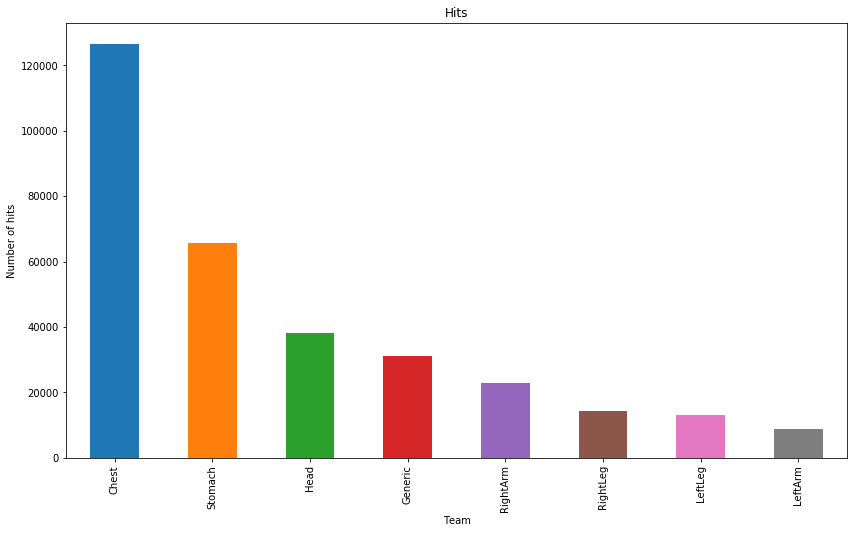

In [32]:
plot = hits['hitbox'].value_counts().plot(kind='bar',figsize=(14,8), title="Hits",)
plot.set_xlabel("Team")
plot.set_ylabel("Number of hits")

So what was the reason for these graphs? I am going to run a a linear regression analysis on whether there is a correlation between the weapon class and where it would hit on somebody. For example if someone has a pistol are they more likely to hit a headshot.

In [7]:
hits["hitbox"] = hits["hitbox"].astype('category')
hits["hitbox_cat"] = hits["hitbox"].cat.codes 

hits["wp_type"] = hits["wp_type"].astype('category')
hits["wp_type_cat"] = hits["wp_type"].cat.codes 
#Turning into integer data

hits["wp"] = hits["wp"].astype('category')
hits["wp_cat"] = hits["wp"].cat.codes 
kill = hits.dropna()

hp_to_bins = []
for i in range(0,len(hits)):
    if (hits["hp_dmg"][i] <=25):
        hp_to_bins.append(0)
    elif (hits["hp_dmg"][i] <= 50):
        hp_to_bins.append(1)
    elif (hits["hp_dmg"][i] <= 75):
        hp_to_bins.append(2)
    else :
        hp_to_bins.append(3)

hits["hp_to_bins"] = hp_to_bins


In [8]:
reg = linear_model.LinearRegression()
data = hits[['hitbox_cat']]
target = hits[['hp_to_bins']]
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size = 0.70, random_state=0)

reg.fit(X_train,y_train)

print ("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [[0.0056581]] + [0.58296906]


In [9]:
predicted = reg.predict(X_test)
mse = ((np.array(y_test)-predicted)**2).sum()/len(y_test)
r2 = r2_score(y_test, predicted)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 0.7674967663926504
R Squared: 0.00037646159569260096


In [10]:
hits.head()

,wp,wp_type,hitbox,hp_dmg,att_rank,hitbox_cat,wp_type_cat,wp_cat,hp_to_bins
0,USP,Pistol,Head,100.0,17.0,2,3,36,3
1,USP,Pistol,RightLeg,25.0,16.0,6,3,36,0
2,Glock,Pistol,LeftLeg,20.0,17.0,4,3,12,0
3,USP,Pistol,Chest,17.0,16.0,0,3,36,0
4,Glock,Pistol,Chest,12.0,17.0,0,3,12,0


In [11]:
clf = MultinomialNB()
data = hits[['wp_cat','hitbox_cat']]
target = hits[['hp_to_bins']]
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size = 0.70, random_state=0)

y_train=y_train.as_matrix()
clf.fit (X_train, y_train)

y_test=y_test.as_matrix()
y_pred = clf.predict(X_test)

y_pred
print("Multinomial:", np.mean(y_pred==y_test))

Multinomial: 0.5036205821425516


So what can we actually do with this? Well not much really. This is just a prediction where if a player has a given gun and hits a hitbox we might be able to predict how much damage is done. For example if someone has a Glock and hits someone on the arm we will know the general range of the damage. Extrapolating from this we can say if we know a given player's skill level and accuracy and what weapon they are using we could possibly predict the damage from this.

Within the game there exists a ranking system, with the 18 different skill ranks available. The higher the rank the more skilled you are at the game. Like the above data exploration I will be using these ranks to split up the dataset and see if there is a significant difference between high level play and low level play. For the purpose of this is defined rank 16 and above as high level and ranks 8 and lower as low level.

In [12]:
highrank=hits[hits.att_rank >=16]
#Separating based on skill level
lowrank = hits[hits.att_rank<=8]

##### High level

In [33]:
plot = highrank['wp'].value_counts().plot(kind='bar',figsize=(14,8), title="Number of hits: High rank",)
plot.set_xlabel("Type of weapon")
plot.set_ylabel("Number of hits")

KeyError: 'wp'

Right away we can see that the AK47 dominates in the graph, almost tripling the second most used weapon. All other weapons taper off at the end with not many being used that much or at all. This is interesting as the AK47 is a terrorist only weapon and yet it has vastly more hits than all the others. Even though the Counter-Terrorists have a choice between 2 rifles even if you add the 2 counts together with the AK-47 still outranks them quite handily. So from this, it is easy to conclude that the AK-47 is a very powerful weapon, making up a large amount of the hits. IT is likely that a Counter-Terrorist if given the chance would pick up an AK-47 and replace their current weapon with it. If we look further on the graph we can see that grenades are used a fair amount, with HE (High Explosive) and Incendiary being the main ones. For each, they would be used for zoning purposes, as incendiary blocks off places with fire and explosive grenades deterring people from moving forward. This will become more relevant as we look at the lower ranked plays.

###### Low level

Text(0,0.5,'Number of hits')

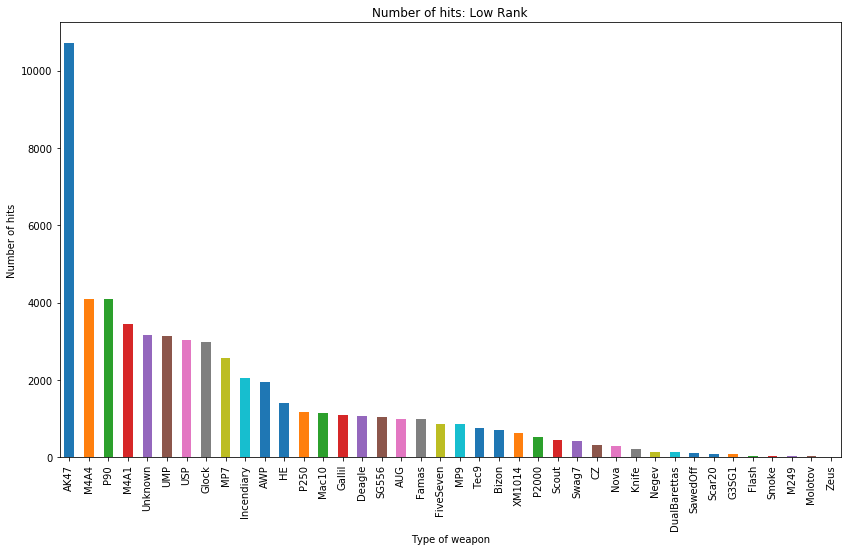

In [14]:
plot = lowrank['wp'].value_counts().plot(kind='bar',figsize=(14,8), title="Number of hits: Low Rank",)
plot.set_xlabel("Type of weapon")
plot.set_ylabel("Number of hits")

So initially the graphs look the same however there are some very key differences within. Just like with high ranked players the AK-47 dominates but it gets more interesting if you look at the other weapons that are used more. For one the P90 has become the third most used weapon and a category called Unknown has popped up. So the P90 has replaced one of the default CT rifles and is used more often. The reason for this is two-fold, the P90  is cheaper to buy at \$2350 with the M4A1 being \$3100. It is also quite a forgiving weapon which explains the jump in popularity in lower ranked play. Higher ranks do not need it as much as a crutch whereas lower ranked players do. The unknown category that popped up is actually environmental damage, caused by jumping off tall things and taking fall damage. It did not appear at all in high ranked play. Low ranked players are also less likely to use incendiary and HE grenades indicating they do not do much zoning at all. If you also look at the proportions at which guns a bought, higher ranked players know which guns and equipment they are going to use with the rest of the equipment tapering off quite quickly. Lower ranked players use a wider variety of weapons either because do not know the “meta” game or because they simply don’t care.

# Looking at the economy
There exists an economy in CSGO which vastly changes the game the strategy of the game. Better equipment costs more money and the better you play the more money is available to you at the start of each round. This of course introduces an element of risk, is it better to save your money and not buy anything or should you buy everything you can for the better chance of winnning. This introduces the idea of different round "types" which has been listed in the master_demos csv file which also has the total equipment value that each team has during any given round. 

In [15]:
economy = df[['round_type','ct_eq_val','t_eq_val']]
economy.head()

,round_type,ct_eq_val,t_eq_val
0,PISTOL_ROUND,2950.0,3850.0
1,PISTOL_ROUND,2950.0,3850.0
2,PISTOL_ROUND,2950.0,3850.0
3,PISTOL_ROUND,2950.0,3850.0
4,PISTOL_ROUND,2950.0,3850.0


In [16]:
economy['round_type'].value_counts()

NORMAL          141253
ECO              83476
FORCE_BUY        46712
PISTOL_ROUND     24926
SEMI_ECO         24083
Name: round_type, dtype: int64

As you can see normal rounds don't actually occur as often as the others, less the half actually.

# Smoke plots

Smoke bombs are a key part of the strategy in CS: GO as it allows you to obscure key points within the map, blocking line of sight or even doing something as simple as throwing it at your feet so the enemy does not know where exactly you are. This data is tracked in mm_grenade_demos with the coordinates of the where the grenade is being thrown from and where it lands being tracked. For this, we do not care about damage or anything like that we are only interested in positioning. With this, we can see where the most common smoke spots are and if they are the same as the positions as the hot spots we found in the heat maps. Much like the weapons I will be splitting this up between high ranked players and lower ranked players to see if there is a difference.
I borrowed code from https://www.kaggle.com/billfreeman44/finding-classic-smokes-by-t-side-on-mirage as I could not get it to work the way I thought I could. Most of this was purely to see the plit between Ranked players.

In [18]:
df_g = pd.read_csv('data/mm_grenades_demos.csv',index_col = 0)
#Cannot use the other data as it only includes damage hits and not grenades thrown

In [26]:
#For the purpose of this I will be looking at only smoke grenades and only at a specific map to make it easier
index=[(df_g['nade']=='Smoke') &
       (df_g['map']=='de_dust2')][0]
smokes=df_g[index]
smokes_clean=smokes[['nade_land_x','nade_land_y','att_rank','att_pos_x','att_pos_y']]

smokes_clean.dropna()
smokes_clean=smokes_clean.reset_index()
smokes_clean.head()

,index,nade_land_x,nade_land_y,att_rank,att_pos_x,att_pos_y
0,3,-431.4837,2126.390,16,151.3117,2304.8010
1,5,-233.6580,1177.997,18,-168.5262,679.0029
2,7,-289.4796,1324.209,17,-467.8509,-359.7883
3,13,-1313.8880,2174.142,17,-1894.4060,1885.6970
4,17,-595.6074,1780.584,16,146.2662,2311.0650


In [27]:
highrank=smokes_clean[smokes_clean.att_rank >=16]
#Splitting the data
lowrank = smokes_clean[smokes_clean.att_rank<=8]

In [28]:
#These definitions are necessary to convert the maps coordinates properly to the map image when we graph it
def pointx_to_resolutionx(xinput, startX=-2486, endX=2127, resX=1024):
    sizeX=endX-startX
    if startX < 0:
        xinput += startX *(-1.0)
    else:
        xinput += startX
    xoutput = float((xinput / abs(sizeX)) * resX);
    return xoutput
def pointy_to_resolutiony(yinput,startY=-1150,endY=3455,resY=1024):
    sizeY=endY-startY
    if startY < 0:
        yinput += startY *(-1.0)
    else:
        yinput += startY
    youtput = float((yinput / abs(sizeY)) * resY);
    return resY-youtput

In [29]:
#Applying changes so we can git it to a map
highrank['thrower_xpos']=highrank['att_pos_x'].apply(pointx_to_resolutionx)
highrank['thrower_ypos']=highrank['att_pos_y'].apply(pointy_to_resolutiony)
highrank['nade_ypos']=highrank['nade_land_y'].apply(pointy_to_resolutiony)
highrank['nade_xpos']=highrank['nade_land_x'].apply(pointx_to_resolutionx)

###### High rank

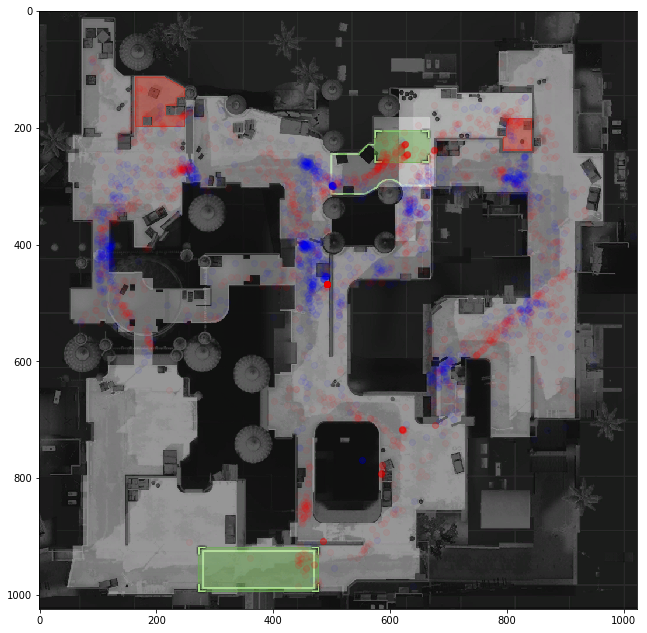

In [30]:
im = plt.imread('data/maps/de_dust2.png')
plt.figure(figsize=(11,11))
t = plt.imshow(im)
t = plt.scatter(highrank['nade_xpos'], highrank['nade_ypos'],alpha=0.05,c='blue')
t = plt.scatter(highrank['thrower_xpos'], highrank['thrower_ypos'],alpha=0.05,c='red')

Blue indicates where the smoke landed and Red indicates where the thrower actually isThere are compartively less data points for high ranked players compared to low ranked players however it paints a slightly better picture. For one the smokes are very localised, there are pretty much none outside of the big of the big areas. The more visible a red dot is the more smokes there are at the specific spot and you can see several around the map especially in the exact middle. This corresponds with the areas found in the heat maps with the most engagements.

##### Low Rank

In [24]:
lowrank['thrower_xpos']=lowrank['att_pos_x'].apply(pointx_to_resolutionx)
lowrank['thrower_ypos']=lowrank['att_pos_y'].apply(pointy_to_resolutiony)
lowrank['nade_ypos']=lowrank['nade_land_y'].apply(pointy_to_resolutiony)
lowrank['nade_xpos']=lowrank['nade_land_x'].apply(pointx_to_resolutionx)

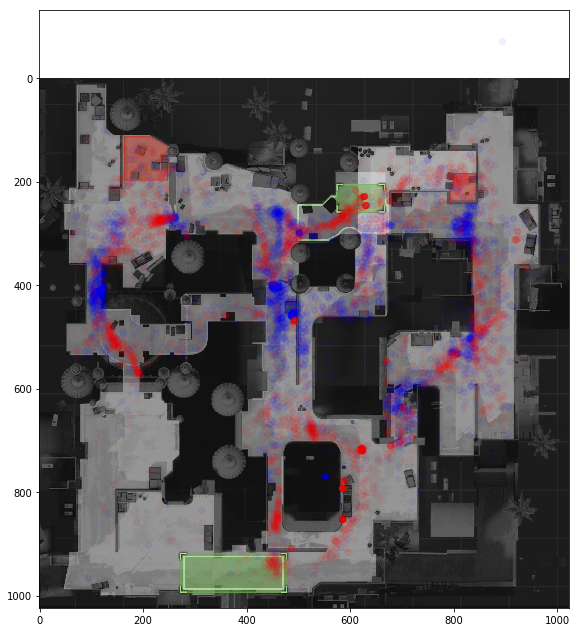

In [25]:
im = plt.imread('data/maps/de_dust2.png')
plt.figure(figsize=(11,11))
t = plt.imshow(im)
t = plt.scatter(lowrank['nade_xpos'], lowrank['nade_ypos'],alpha=0.05,c='blue')
t = plt.scatter(lowrank['thrower_xpos'], lowrank['thrower_ypos'],alpha=0.05,c='red')

Again Blue is where the smoke landed and red is where the thrower is from. The main difference between low ranked and high ranked players is that low ranked players tended to throw a lot more randomly and less precisely. There are far more faint trails from people throwing it everywhere instead of just concentrated areas. One person even throw it outside of the map completely hence why the map is slightly off

### Overall Rank Analysis
From both smoke grenades and weapon analysis, we can see that being a high rank does not necessarily guarantee a better player however it usually shows a far more consisten and precise player which generally gives a boost in performance and an overall higher chance of winning